In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import collections
from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# train

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/RNN/train_dataset.csv')

In [ ]:
train.head()

,text,label,label_name
0,i feel loyal to poor janie who has been helpin...,2,love
1,i am feeling discontent i am wasting time wish...,0,sadness
2,im not feeling that sentimental,0,sadness
3,i really feel that if one is strong about what...,1,joy
4,i have managed to get a few things done from t...,1,joy


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300102 entries, 0 to 300101
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        300102 non-null  object
 1   label       300102 non-null  int64 
 2   label_name  300102 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.9+ MB


In [ ]:
print("Duplicate entries in the dataset: " + str(train.duplicated().sum()))

Duplicate entries in the dataset: 353


In [ ]:
train = train.drop_duplicates()

In [ ]:
print("Duplicate entries in the dataset: " + str(train.duplicated().sum()))

Duplicate entries in the dataset: 0


In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict )
train.head()

,text,label,label_name,description
0,i feel loyal to poor janie who has been helpin...,2,love,love
1,i am feeling discontent i am wasting time wish...,0,sadness,sadness
2,im not feeling that sentimental,0,sadness,sadness
3,i really feel that if one is strong about what...,1,joy,joy
4,i have managed to get a few things done from t...,1,joy,joy


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords_english = set(stopwords.words('english'))
my_stopwords = set(["don'", "'ve", "href","http", "n't", "'m", "'re"])
#my_stopwords = set(["don'", "S", "'ve", "U", "t", "co", "href", "m","http", "n't", "'m", "'re"])
stopwords_english.update(my_stopwords)

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'\d+', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    tokens = text.split()

    clean_tokens = [tok for tok in tokens if tok not in stopwords_english and len(tok) > 1]

    clean_text = ' '.join(clean_tokens)

    return clean_text

In [ ]:
sample = train['text'][100]

print('ORIGINAL REVIEW:   ' + sample + '\n')

print('WITH PROCESSING:    ' + preprocess_text(sample))

ORIGINAL REVIEW:   i feel dumb asking mum for money

WITH PROCESSING:    feel dumb asking mum money


# Train

In [ ]:
train["clean_text"] = train["text"].apply(preprocess_text)

In [ ]:
train.head()

,text,label,label_name,description,clean_text
0,i feel loyal to poor janie who has been helpin...,2,love,love,feel loyal poor janie helping hate take away c...
1,i am feeling discontent i am wasting time wish...,0,sadness,sadness,feeling discontent wasting time wishing things...
2,im not feeling that sentimental,0,sadness,sadness,im feeling sentimental
3,i really feel that if one is strong about what...,1,joy,joy,really feel one strong really want one stop
4,i have managed to get a few things done from t...,1,joy,joy,managed get things done backlog evening home c...


In [ ]:
train['clean_length_of_text'] = [len(i.split(' ')) for i in train['clean_text']]
train['normal_length_of_text'] = [len(i.split(' ')) for i in train['text']]

In [ ]:
train.head()

,text,label,label_name,description,clean_text,clean_length_of_text,normal_length_of_text
0,i feel loyal to poor janie who has been helpin...,2,love,love,feel loyal poor janie helping hate take away c...,9,20
1,i am feeling discontent i am wasting time wish...,0,sadness,sadness,feeling discontent wasting time wishing things...,16,32
2,im not feeling that sentimental,0,sadness,sadness,im feeling sentimental,3,5
3,i really feel that if one is strong about what...,1,joy,joy,really feel one strong really want one stop,8,21
4,i have managed to get a few things done from t...,1,joy,joy,managed get things done backlog evening home c...,14,30


In [ ]:
train = train.drop(columns=['text'])

# test

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/RNN/test_dataset.csv')


In [ ]:
test.head()

,text,label,label_name
0,i really do want to believe that it s a misund...,2,love
1,i was at the point in my life where i needed t...,1,joy
2,i alternate between feeling sympathetic toward...,2,love
3,im feeling very proud,1,joy
4,i havent really posted anything on fashion for...,0,sadness


In [ ]:
test["clean_text"] = test["text"].apply(preprocess_text)

In [ ]:
test.head()

,text,label,label_name,clean_text
0,i really do want to believe that it s a misund...,2,love,really want believe misunderstanding whole dea...
1,i was at the point in my life where i needed t...,1,joy,point life needed change since feel like ive a...
2,i alternate between feeling sympathetic toward...,2,love,alternate feeling sympathetic toward hum
3,im feeling very proud,1,joy,im feeling proud
4,i havent really posted anything on fashion for...,0,sadness,havent really posted anything fashion quite ma...


In [ ]:
test = test.drop(columns=['text'])

# Validation

In [ ]:
validation = pd.read_csv('/content/drive/MyDrive/RNN/validation_dataset.csv')

In [ ]:
validation.head()

,text,label,label_name
0,i have a moment feel particularly dirty a href...,0,sadness
1,i was feeling pretty confident that he must be...,1,joy
2,i feel like we are now on our way to learning ...,1,joy
3,i feel like i cant think logically at all beca...,0,sadness
4,i have primarily identified myself with trans ...,3,anger


In [ ]:
validation["clean_text"] = validation["text"].apply(preprocess_text)

In [ ]:
validation.head()

,text,label,label_name,clean_text
0,i have a moment feel particularly dirty a href...,0,sadness,moment feel particularly dirty polarwerk
1,i was feeling pretty confident that he must be...,1,joy,feeling pretty confident must kid hes excited ...
2,i feel like we are now on our way to learning ...,1,joy,feel like way learning successful th graders
3,i feel like i cant think logically at all beca...,0,sadness,feel like cant think logically start getting w...
4,i have primarily identified myself with trans ...,3,anger,primarily identified trans men group relativel...


In [ ]:
validation = validation.drop(columns=['text'])

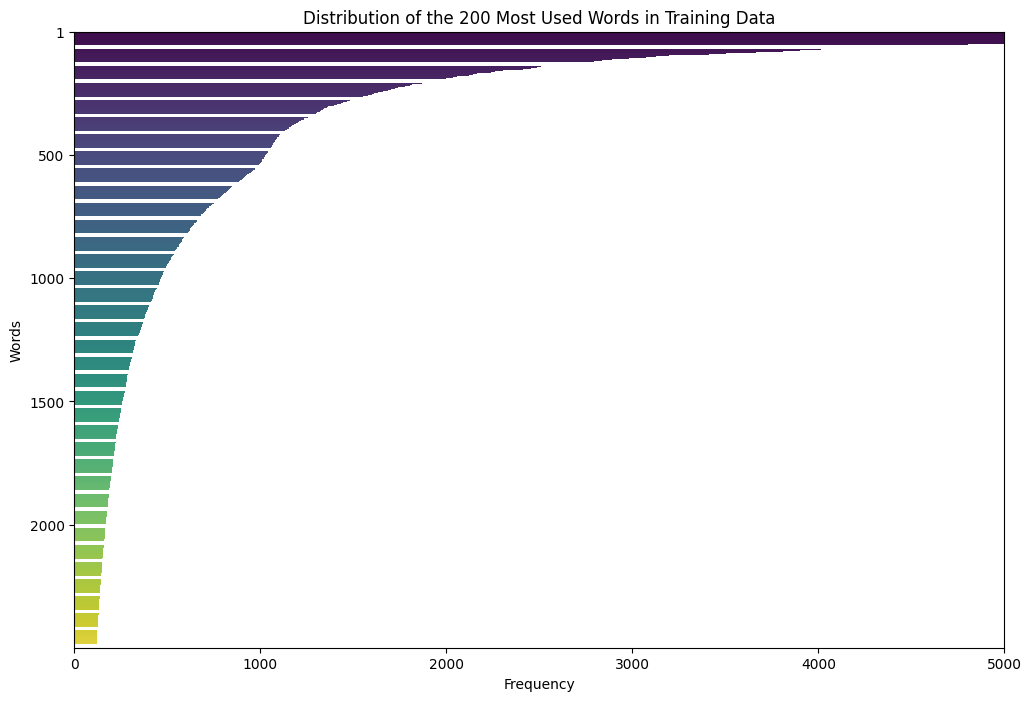

In [ ]:
all_words = ' '.join(train['clean_text']).split()
word_counts = Counter(all_words)
top_1500_words = word_counts.most_common(2500)

top_words = [word[0] for word in top_1500_words]
top_counts = [word[1] for word in top_1500_words]

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_counts, y=top_words, palette="viridis")
plt.title("Distribution of the 2500 Most Used Words in Training Data")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.xlim(0, 5000)

# Custom y-axis ticks and labels
y_positions = [0, 500, 1000, 1500, 2000]  # Positions for the labels
y_labels = [1, 500, 1000, 1500, 2000]     # The labels themselves

# Adjust y_positions if it exceeds the number of bars
y_positions = [pos for pos in y_positions if pos < len(top_words)]
y_labels = y_labels[:len(y_positions)]

ax.set_yticks(y_positions)  # Set tick positions
ax.set_yticklabels(y_labels)  # Set tick labels

plt.show()

In [ ]:
X_tr = train["clean_text"].values
y_tr = train["label"].values

X_va = validation["clean_text"].values
y_va = validation["label"].values

In [ ]:
X_te = test["clean_text"].values
y_te = test["label"].values

In [ ]:
print("Training data:", X_tr.shape, y_tr.shape)
print("Validation data:", X_va.shape, y_va.shape)
print("Test data:", X_te.shape)

Training data: (299749,) (299749,)
Validation data: (75026,) (75026,)
Test data: (41681,)


In [ ]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_tr)

max_seq_length = 200

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_tr_seq = pad_sequences(X_tr_seq, maxlen=max_seq_length)

X_va_seq = tokenizer.texts_to_sequences(X_va)
X_va_seq = pad_sequences(X_va_seq, maxlen=max_seq_length)

X_te_seq = tokenizer.texts_to_sequences(X_te)
X_te_seq = pad_sequences(X_te_seq, maxlen=max_seq_length)

In [ ]:
X_tr_seq

array([[   0,    0,    0, ...,  131,   71,   83],
       [   0,    0,    0, ..., 1744,  122,  266],
       [   0,    0,    0, ...,    4,    2,  611],
       ...,
       [   0,    0,    0, ...,   24,   95,  317],
       [   0,    0,    0, ...,  117,    2,  574],
       [   0,    0,    0, ...,   50,  684,    7]], dtype=int32)

In [ ]:
import pickle
# Save the tokenizer
with open('/content/drive/MyDrive/RNN/tokenizer1234.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [ ]:
#base model
embedding_dimension = 128
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=1501,
                              output_dim=embedding_dimension,
                              input_length=150,
                              name="embedding"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
#Model 2 with added bidirectional(LSTM) and dropout
embedding_dimension = 128
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=1501,
                              output_dim=embedding_dimension,
                              input_length=150,
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.LSTM(64),                                                        # Second LSTM layer
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer='l2')           # L2 regularization
])

In [ ]:
#Model 3
embedding_dimension = 128
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=2001,
                              output_dim=embedding_dimension,
                              input_length=200,
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.GRU(64, return_sequences=True),                                   # Added GRU layer
    tf.keras.layers.LSTM(64),                                                        # Second LSTM layer
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer='l2')           # L2 regularization
])

In [ ]:
# model 4
embedding_dimension = 128
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=1501,
                              output_dim=embedding_dimension,
                              input_length=150,
                              name="embedding"),
    tf.keras.layers.GRU(64),  # Replaced LSTM with GRU
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
#model 5
embedding_dimension = 128
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=2001,
                              output_dim=embedding_dimension,
                              input_length=200,
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    tf.keras.layers.BatchNormalization(),                                           # Batch Normalization after Bidirectional LSTM
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.GRU(64, return_sequences=True),                                   # Added GRU layer
    tf.keras.layers.BatchNormalization(),                                           # Batch Normalization after GRU
    tf.keras.layers.LSTM(64),                                                        # Second LSTM layer
    tf.keras.layers.BatchNormalization(),                                           # Batch Normalization after second LSTM
    tf.keras.layers.Dropout(0.2),                                                    # Dropout
    tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer='l2')           # L2 regularization
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)




In [ ]:
from tensorflow import keras
from sklearn.model_selection import KFold

# Define the hyperparameter search space
param_grid = {
    'embedding_dimension': [32, 64, 128],
    'lstm_units': [32, 64, 128],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}

# Initialize variables to store the best hyperparameters and performance
best_params = {}
best_score = 0.0

# Implement nested loops for grid search
for embedding_dim in param_grid['embedding_dimension']:
    for lstm_units_val in param_grid['lstm_units']:
        for learning_rate_val in param_grid['learning_rate']:
            # Build the model with current hyperparameters
            model = keras.Sequential([
                keras.layers.Embedding(input_dim=1501, output_dim=embedding_dim, input_length=150),
                keras.layers.LSTM(lstm_units_val),
                keras.layers.Dense(6, activation='softmax')
            ])
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_val),
                          loss='sparse_categorical_crossentropy',
                          metrics=['acc'])

            # Perform k-fold cross-validation (e.g., k=5)
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = []
            for train_index, val_index in kfold.split(X_tr_seq):
                X_train_fold, X_val_fold = X_tr_seq[train_index], X_tr_seq[val_index]
                y_train_fold, y_val_fold = y_tr[train_index], y_tr[val_index]

                model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, callbacks=[early_stopping])
                _, score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                scores.append(score)

            # Average the cross-validation scores
            avg_score = np.mean(scores)

            # Update best hyperparameters and performance if current configuration is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'embedding_dimension': embedding_dim,
                    'lstm_units': lstm_units_val,
                    'learning_rate': learning_rate_val
                }

# Print the best hyperparameters and performance
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Epoch 1/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - acc: 0.8776 - loss: 0.2863 - val_acc: 0.9238 - val_loss: 0.1505
Epoch 2/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9239 - loss: 0.1526 - val_acc: 0.9243 - val_loss: 0.1480
Epoch 3/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9246 - loss: 0.1498 - val_acc: 0.9243 - val_loss: 0.1535
Epoch 4/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9234 - loss: 0.1509 - val_acc: 0.9234 - val_loss: 0.1512
Epoch 5/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9251 - loss: 0.1492 - val_acc: 0.9231 - val_loss: 0.1513
Epoch 1/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9232 - loss: 0.1530 - val_acc: 0.9235 - val_loss: 0.1528
Epoch 2/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9248 - loss: 0.1516 - val_acc: 0.9224 - val_loss: 0.1525
Epoch 3/10
7494/7494 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - acc: 0.9241 - loss: 0.1522 - val_acc: 0.9223 - val_loss: 0.1525
Epoch 4/10
7494/7494 ━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model3.compile(optimizer=Adam(learning_rate = 0.0001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc']
                 )

model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model3.fit(X_tr_seq,
                    y_tr,
                    validation_data=(X_va_seq, y_va),
                    batch_size=64,
                    epochs=25,
                    verbose=1,
                    callbacks=[early_stopping]
                   )

Epoch 1/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 165s 34ms/step - acc: 0.6626 - loss: 0.9728 - val_acc: 0.8746 - val_loss: 0.4216
Epoch 2/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 157s 34ms/step - acc: 0.8813 - loss: 0.3816 - val_acc: 0.8862 - val_loss: 0.3370
Epoch 3/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 159s 34ms/step - acc: 0.8874 - loss: 0.3375 - val_acc: 0.8913 - val_loss: 0.3091
Epoch 4/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 158s 34ms/step - acc: 0.8928 - loss: 0.3091 - val_acc: 0.8981 - val_loss: 0.2834
Epoch 5/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 158s 34ms/step - acc: 0.9035 - loss: 0.2705 - val_acc: 0.9109 - val_loss: 0.2347
Epoch 6/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 158s 34ms/step - acc: 0.9164 - loss: 0.2268 - val_acc: 0.9199 - val_loss: 0.2027
Epoch 7/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 158s 34ms/step - acc: 0.9235 - loss: 0.1975 - val_acc: 0.9243 - val_loss: 0.1840
Epoch 8/25
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 158s 34ms/step - acc: 0.9287 - loss: 0.1773 - val_acc: 0.9277 - val_loss: 0.1712
Epoch 9/25
4684/

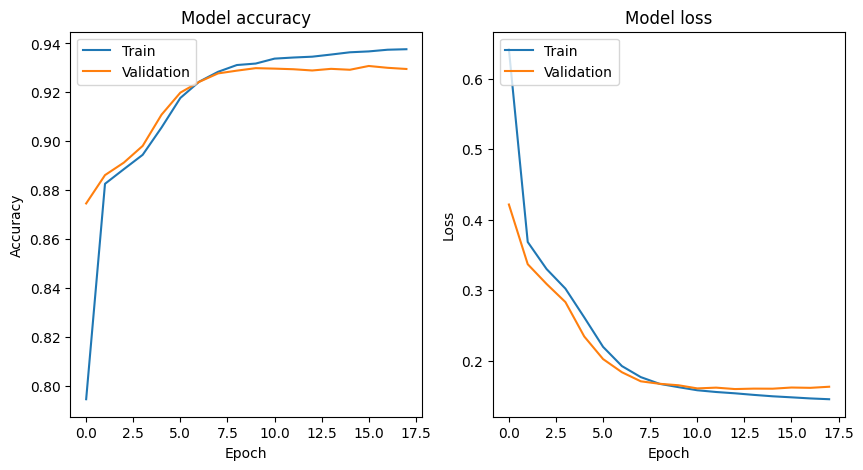

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import h5py
# Save the trained model
model3.save('/content/drive/MyDrive/RNN/my_rnn_model1234.keras')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
train_loss3, train_acc3 = model3.evaluate(X_tr_seq,y_tr)

print('Train loss:', train_loss3)
print('train accuracy:', train_acc3)

9368/9368 ━━━━━━━━━━━━━━━━━━━━ 123s 13ms/step - acc: 0.9372 - loss: 0.1453
Train loss: 0.14482977986335754
train accuracy: 0.9374476671218872


In [ ]:
test_loss, test_acc = model3.evaluate(X_va_seq,y_va)

print('Validation loss:', test_loss)
print('Validation accuracy:', test_acc)

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - acc: 0.9301 - loss: 0.1559
Validation loss: 0.16021022200584412
Validation accuracy: 0.9289312958717346


In [ ]:
# Evaluate the model on test data
test_loss2, test_acc2 = model3.evaluate(X_te_seq, y_te)

print('Test loss:', test_loss2)
print('Test accuracy:', test_acc2)


1303/1303 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - acc: 0.9329 - loss: 0.1558
Test loss: 0.15776896476745605
Test accuracy: 0.930184006690979


In [ ]:
pred = [np.argmax(i) for i in model3.predict(X_va_seq)]

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step


In [ ]:
predictions = [np.argmax(i) for i in model3.predict(X_te_seq)]

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step


In [ ]:
cm_raw = confusion_matrix(y_te, predictions)
cm_raw


array([[11740,    42,     0,   191,    89,     0],
       [   50, 13055,   921,    81,    17,     3],
       [    3,   167,  3304,     4,     4,     3],
       [  190,    45,     2,  5296,   147,     0],
       [  175,    15,     2,   168,  4400,    11],
       [   13,   156,     4,     2,   405,   976]])

In [ ]:
cm_norm = confusion_matrix(y_va, pred, normalize='true')
cm_norm

array([[9.88474607e-01, 4.31628249e-03, 4.13261089e-04, 5.14280467e-03,
        1.37753696e-03, 2.75507393e-04],
       [8.84574739e-03, 9.78355317e-01, 3.05295706e-03, 4.61857607e-03,
        5.47966652e-04, 4.57943559e-03],
       [7.30400909e-03, 2.96380458e-01, 6.89823081e-01, 4.86933939e-03,
        3.24622626e-04, 1.29849050e-03],
       [7.08646067e-02, 9.35763720e-03, 1.07222926e-03, 8.78740618e-01,
        3.87952042e-02, 1.16970465e-03],
       [6.17571662e-02, 5.01048707e-03, 4.66091820e-04, 1.18853414e-02,
        8.58657656e-01, 6.22232580e-02],
       [1.40897293e-02, 6.04375232e-02, 7.41564702e-04, 2.22469410e-03,
        1.07156099e-01, 8.15350389e-01]])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision_val = precision_score(y_va, pred, average='weighted')
recall_val = recall_score(y_va, pred, average='weighted')
f1_val = f1_score(y_va, pred, average='weighted')
accuracy_val = accuracy_score(y_va, pred)

print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)
print("Validation F1-score:", f1_val)
print("Validation Accuracy:", accuracy_val)

Validation Precision: 0.9330313925457259
Validation Recall: 0.9289313038146776
Validation F1-score: 0.9287366243339414
Validation Accuracy: 0.9289313038146776


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision_test = precision_score(y_te, predictions, average='weighted')
recall_test = recall_score(y_te, predictions, average='weighted')
f1_test = f1_score(y_te, predictions, average='weighted')
accuracy_test = accuracy_score(y_te, predictions)


print("Testing Precision:", precision_test)
print("Testing Recall:", recall_test)
print("Testing F1-score:", f1_test)
print("Testing Accuracy:", accuracy_test)

Testing Precision: 0.9345230582368775
Testing Recall: 0.9301840166982558
Testing F1-score: 0.9299332608927
Testing Accuracy: 0.9301840166982558
